# HashStream: Tutorial

To start, let's import some packages to help us. If you haven't read `README.md`, you should go do that now. I **highly** recommend Continuum Analytics **Anaconda** distribution of python, and the `conda` architecture for finding/installing co-dependent packages. Go explore! 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;

/home/tbsexton/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Preprocessing tweet data

Now, all we need to start collecting tweet data is the `preprocess` module, which contains the `Preprocess` class for extracting hashtags and timestamps from raw tweet data. 

Once that's done, all you need to create the preprocess object is to specify the file it will monitor. This object is tied to that file...whether it will be a static or dynamic source of raw twee data

In [2]:
from src.preprocess import Preprocess

In [3]:
pre = Preprocess('./tweet_input/tweets.txt')
pre.extract()

Parsing JSON objects...
Done!
Parsed 9295 Tweets.
Dropped 704 Tweets with missing information.
Total tweets in storage: 9295


Let's say that file got updated with fresh tweets at the end, but still had the old tweets inside. If we extract with the `overwrite=False` flag, the Preprocessing object tracks where it left off, and skips ahead to ONLY read in new tweets. This let's us use the preprocessor even on live-streamed data. HashStream is very scalable!

Since the example `tweets.txt` file hasn't changed, there shouldn't be anything added:

In [4]:
pre.extract(overwrite=False)

Parsing JSON objects...
Done!
Parsed 0 Tweets.
Dropped 0 Tweets with missing information.
Total tweets in storage: 9295


Another important feature of the preprocessor is it's use of Pandas, which gives us an R style dataframe for manipulation as we please...and its handling of timestamps and slicing is amazing! Access this dataframe with `Preprocess.df`: 

In [5]:
print len(pre.df.index)
pre.df.head()

9295


,hashtags,time
0,[],2016-03-28 23:23:12
1,[],2016-03-28 23:23:12
2,[],2016-03-28 23:23:12
3,[],2016-03-28 23:23:11
4,"[hiring, PaloAlto, Healthcare, Job, Jobs]",2016-03-28 23:23:12


If we want the average number of hashtags for all tweets in storage, that's easy!

In [6]:
np.mean([len(i) for i in pre.df])

6.0

### Analyzing the data
This is where things get cool. use `import src.analysis` to get access to the main toolbox in HashStream, currently called `analysis`. Let's import as `hs`, and check out what the `__all__` keyword would give us (i.e. the functions `from src.analysis import *` would return)

In [7]:
import src.analysis as hs

hs.__all__

['rolled_graph_gen', 'g_stats', 'draw_lifted', 'get_graphs', 'mean_deg']

Remember that we are building graphs from the *shared* hashtags among tweets...an edge between hastags means they occured together (in the same tweet) at some point in the time window . 

The `get_graphs()` function will do just that. Specify a starting tweet and an ending tweet (for 1 tweet, --> start, start+1). None of the tweets before No. 4 returned any hashtags so let's see what tweet 4 gives us: 

1


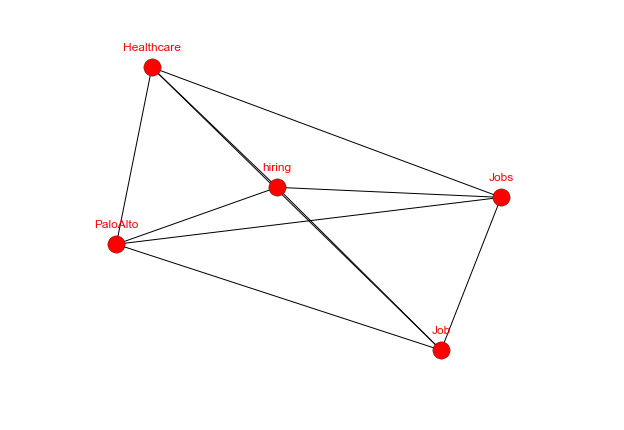

In [8]:
tweet_no = 4

g = hs.get_graphs(pre.df, tweet_no,tweet_no+1, window=10.)
print len(g)
hs.draw_lifted(g[0])

Cool, huh? All are connected because they all were in the 4th tweet. Note the `draw_lifted()` function, which draws the graph with labels 'lifted' above the node. THIS NEEDS MATPLOTLIB!

Now lets add 100 tweets and see what's what. 

1


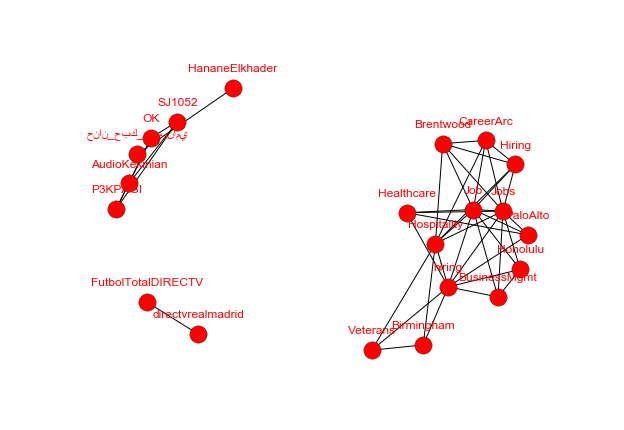

In [9]:
tweet_no = 4+100

g = hs.get_graphs(pre.df, tweet_no,tweet_no+1, window=10.)
print len(g)
hs.draw_lifted(g[0])

Ok, so what's really going on under the hood, is a python generator that calculated the proper time window and graph structure on the fly. the `rolled_graph_gen()` function is the direct way to make a custom generator. 

Start and end at whatever tweet you like (defaults are beginning and ending of the input dataframe). Then pick your time window to smooth the graphs a bit. I like 10 seconds, so let's check out what happens after the 8000th tweet: 

In [10]:
graph_gen = hs.rolled_graph_gen(pre.df, start=8000, window=10.)

Cool. Now, the `g_stats()` function will calculate any statistics you want, by passing in functions that can take NetworkX graphs as input and output a value. Put as many as you like, and the statistics are saved as columns in the output array. 

Also, using a `savename='path/to/file.txt'` kwarg will creat a .txt to save your desired statistics! Hashstream has a `mean_deg()` utility function to calculate the mean degree of the hashtag nodes in a graph, but it's easy to define and use your own. 

In [11]:
# quick function to extract the timestamp for each graph
get_times = lambda g: g.graph['time'] 

X = hs.g_stats(graph_gen, hs.mean_deg, get_times)

If `tqdm` is installed, you should get a nice looking progress bar as the generator creates graphs for the stats function on the fly. If not, wait a little bit until it finishes. 

Now, it's easy to see what the last thousand or so tweets are doing. 

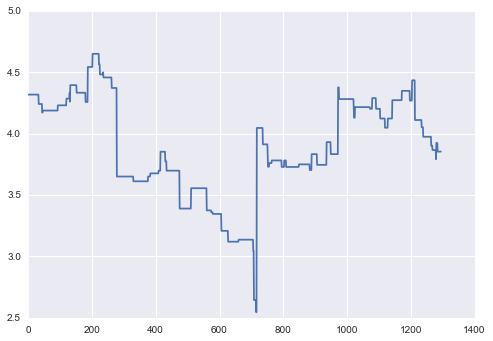

In [12]:
degrees, times = X[:,0], X[:,1]

plt.plot(degrees)

Since this is built on Pandas dataframes, it's also easy to plot vs. time! Since our dataset is only resolved to seconds, there will of course be some overlap, so we'll use dots instead. 

(array([ 736052.25309028,  736052.25314815,  736052.25320602,
         736052.25326389,  736052.25332176]),
 <a list of 5 Text xticklabel objects>)

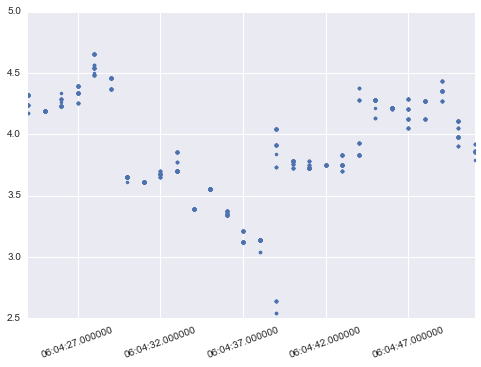

In [13]:
plt.plot(times, degrees, '.')
plt.xticks(rotation=20)
# X.shape

It's easy to check out the distributions of the data with packages like Seaborn or your plotting package of choice. 

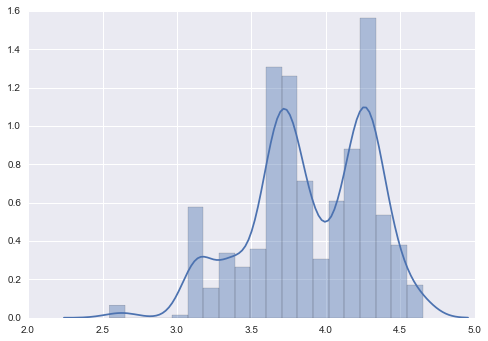

In [14]:
sns.distplot(degrees)

### Static data crunching

If you have all the tweets you want, it may be better to just save all of the graph objects you'll need in one go. The generator makes this easy, but expect to wait a while the first time around. 

In [15]:
graph_list = hs.get_graphs(pre.df, window=10.)

Now we can directly access the graph objects and all of their attributes at once! For example, the first graph recorded (which we saw before). 

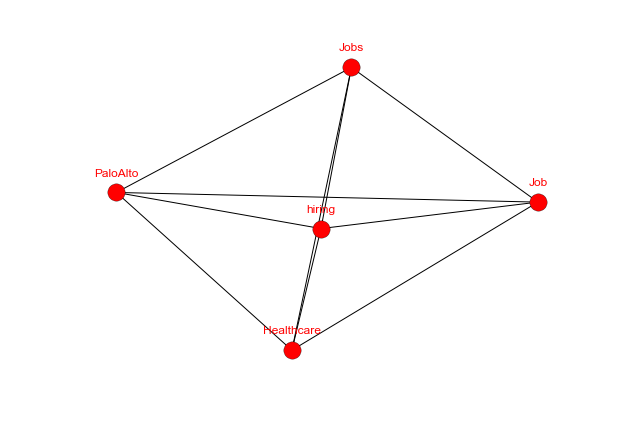

In [16]:
hs.draw_lifted(graph_list[0])

Now, we can pass the graph **list** (instead of a generator) into the stats function. What does the MOST connected (on average) graph look like? The LEAST?

[7, 7, 7, 7, 7, 7, 7, 7]


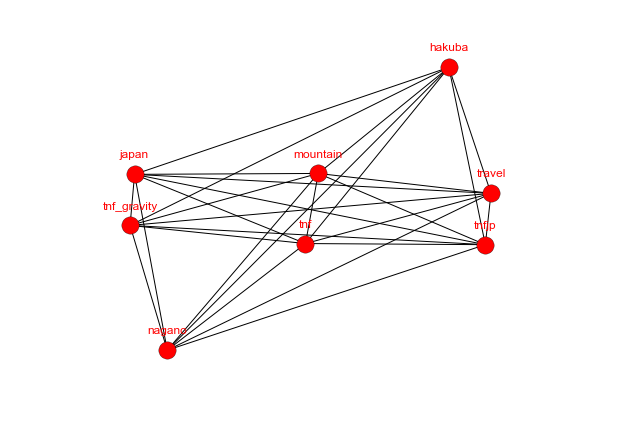

In [17]:
X = hs.g_stats(graph_list, hs.mean_deg, get_times)
degrees, times = X[:,0], X[:,1]

g = graph_list[np.argmax([degrees])]
print g.degree().values()

hs.draw_lifted(g)

[1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


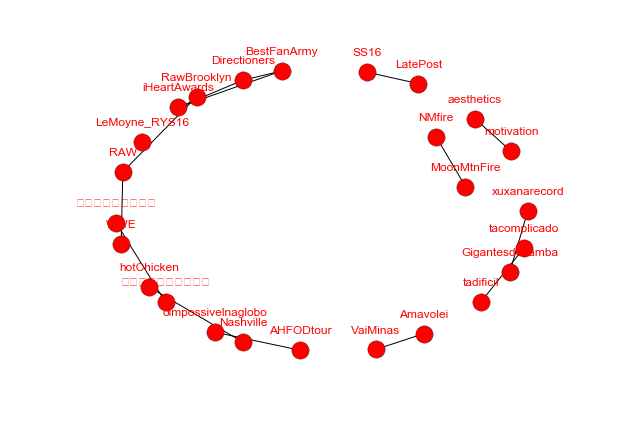

In [18]:
g = graph_list[np.argmin([degrees])]
print g.degree().values()

hs.draw_lifted(g)

### Dynamic Input

The twitter API is not currenly implemented into HashStream, though that is planned for the future. But, if you set up the input file (being tracked by the preprocessor) to change, it's really easy to write a loop to continuously track the mean degree. Here's an example: 
***

```python
pre = Preprocessing('path/to/raw/data.txt')
pre.extract()
pos = len(pre.df.index)

gen = hs.rolled_graph_gen(pre.df)
degs = hs.g_stats(gen, hs.mean_deg).tolist()

while True:
    
    pre.extract(overwrite=False)
    gen = hs.rolled_graph_gen(pre.df, start=pos)
    degs += hs.g_stats(gen, hs.mean_deg).tolist()
    
    pos = len(pre.df.index)
    
```
***
This will let you send the degrees to something like the [plot.ly streaming API](https://plot.ly/streaming/). 